**ФЕДЕРАЛЬНОЕ АГЕНСТВО ЖЕЛЕЗНОДОРОЖНОГО ТРАНСПОРТА**

Федеральное государственное бюджетное образовательное учреждение высшего образования

«ПЕТЕРБУРГСКИЙ ГОСУДАРСТВЕННЫЙ УНИВЕРСИТЕТ ПУТЕЙ СООБЩЕНИЯ Императора Александра I»

---

**Кафедра «Информационные и вычислительные системы»**

Дисциплина «Архитектура вычислительных систем»

**ОТЧЁТ**

**ПО ЛАБОРАТОРНОЙ РАБОТЕ №2**

**«МОДЕЛИРОВАНИЕ И АНАЛИЗ ТОПОЛОГИЙ СЕТЕЙ МЕЖСОЕДИНЕНИЙ»**

---

Выполнил студент

Факультет: АИТ

Группа: ИВБ-211

А. Шефнер

---

Проверил:	В.А. Гончаренко

# Цель занятия

Изучение основных топологий сетей межсоединений вычислительных систем,
освоение методики расчета их ключевых метрик, исследование функций маршрутизации
данных и установление соответствия между топологиями и архитектурными классами ВС.

# Ход работы

Импорты для всего блокнота

In [1]:
from dataclasses import dataclass, asdict, is_dataclass
from math import floor, ceil, sqrt
from IPython.display import HTML
from functools import cache
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np


Функции отображения табличных данных

In [2]:
def render_cell(cell):
    return f"        <td>{cell}</td>\n"


def display_table_lists(data, headers=None):
    result = "<table>\n"

    if headers:
        result += "  <thead>\n"
        result += "    <tr>\n"
        for header in headers:
            result += f"      <th>{header}</th>"
        result += "    </tr>\n"
        result += "  </thead>\n"

    result += "  <tbody>\n"
    for row in data:
        result += "    <tr>\n"

        if is_dataclass(row):
            for key, value in asdict(row).items():
                result += render_cell(value)
        else:
            for cell in row:
                result += render_cell(cell)

        result += "    </tr>\n"
    result += "  </tbody>\n"
    result += "</table>\n"
    display(HTML(result))


def display_table_dicts(data, headers=None):
    keys = list(data[0].keys())
    data = [[dic[key] for key in dic] for dic in data]
    headers = headers if headers else keys
    display_table_lists(data, headers)


def display_table_dataclasses(data, headers=None):
    display_table_dicts([asdict(obj) for obj in data], headers)


def display_table(data, headers=None):
    first = data[0]
    if isinstance(first, list):
        display_table_lists(data, headers)
    elif isinstance(first, dict):
        display_table_dicts(data, headers)
    elif is_dataclass(first):
        display_table_dataclasses(data, headers)
    else:
        raise ValueError("Unsupported type")

## Задание 1

Определение модели метрик

In [3]:
@dataclass
class Metrics:
    name: str
    size: float
    diameter: float
    average_power: float
    coherence: float
    bisection_width: float
    bisection_band: float
    channels: float
    cost: float


@dataclass
class VariantData:
    N_full: float
    N_line: float
    N_ring: float
    R_star: float
    B_tree: float
    D_tree: float
    m_mesh: float
    n_mesh: float
    d_hypercube: float
    N_route: float
    throughoutput: float
    shift_S: int

Вычисление исходных данных по варианты

In [4]:
def get_variant_data(group, number):
    G = int("ИВБ-211"[-3:])
    S = number % 100
    return VariantData(
        N_full=(G % 7) + 4,
        N_line=(G % 6) + 5,
        N_ring=(G % 5) + 4,
        R_star=(S % 4) + 3,
        B_tree=(G % 3) + 2,
        D_tree=(S % 3) + 2,
        m_mesh=(G % 4) + 2,
        n_mesh=(S % 4) + 2,
        d_hypercube=(G % 4) + 2,
        N_route=2 ** ((G % 4) + 2),
        throughoutput=((S % 5) + 1) * 100,
        shift_S = number % 10
    )


d = get_variant_data("ИВБ-211", 13)
display_table([d])

N_full,N_line,N_ring,R_star,B_tree,D_tree,m_mesh,n_mesh,d_hypercube,N_route,throughoutput,shift_S
5,6,5,4,3,3,5,3,5,32,400,3


## Графическое представление

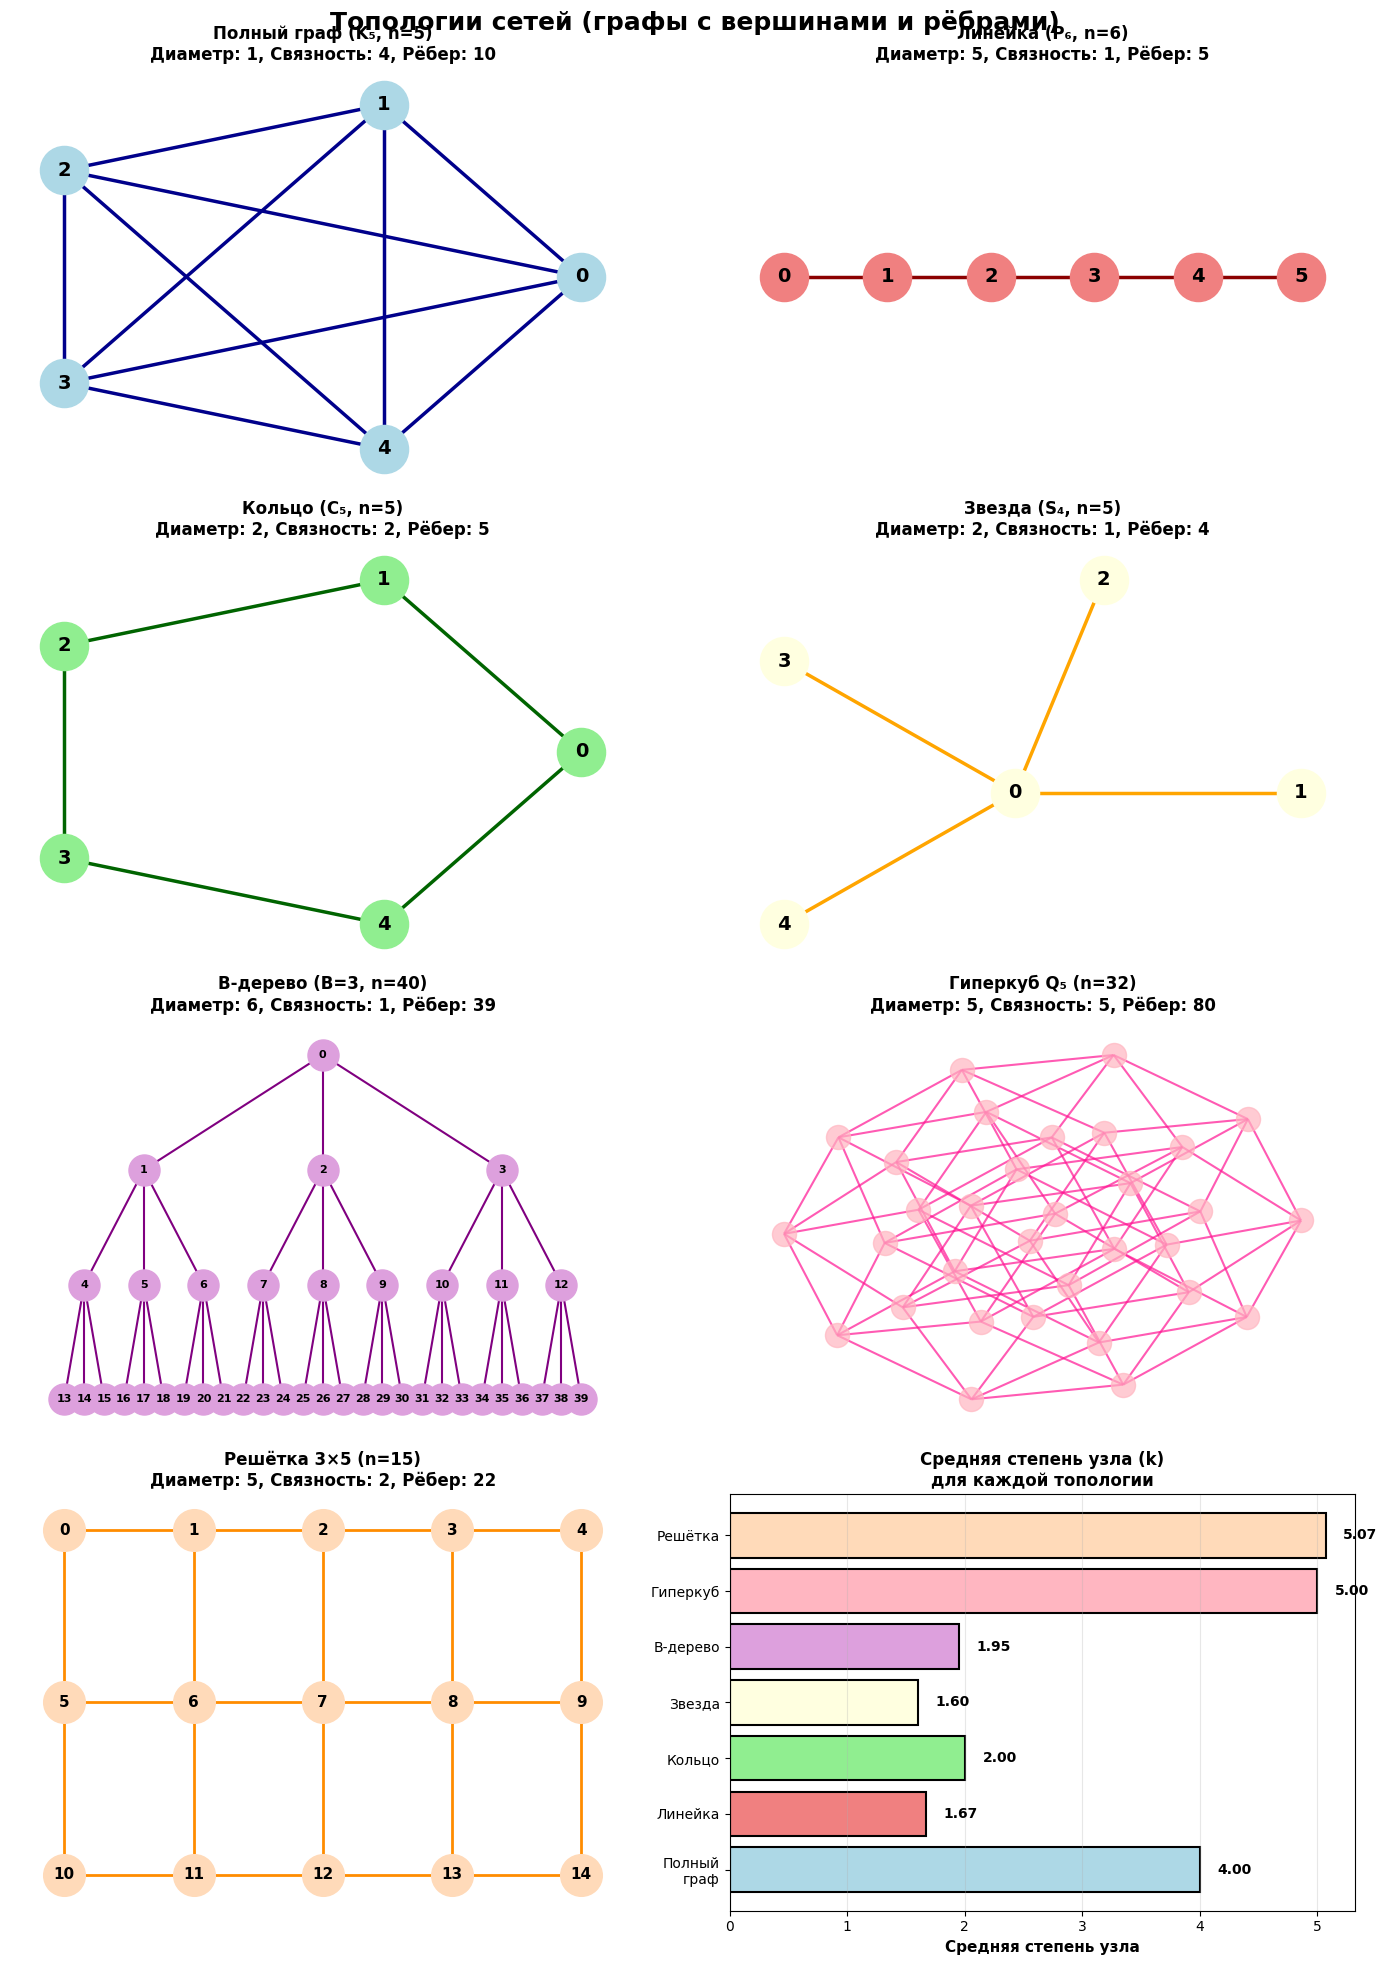

In [5]:
# Define hierarchy_pos function for tree layout
def hierarchy_pos(G, root=None, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5, pos=None, parent=None):
    """
    Create hierarchical layout for tree graphs
    """
    if pos is None:
        pos = {root: (xcenter, vert_loc)}
    else:
        pos[root] = (xcenter, vert_loc)
    
    children = [n for n in G.neighbors(root) if n != parent]
    if len(children) != 0:
        dx = width / len(children)
        nextx = xcenter - width/2 - dx/2
        for child in children:
            nextx += dx
            pos = hierarchy_pos(G, child, width=dx, vert_gap=vert_gap,
                              vert_loc=vert_loc-vert_gap, xcenter=nextx,
                              pos=pos, parent=root)
    return pos

fig, axes = plt.subplots(4, 2, figsize=(14, 20))
fig.suptitle('Топологии сетей (графы с вершинами и рёбрами)', fontsize=18, fontweight='bold')

axes = axes.flatten()

# 1. Complete Graph (Полный граф) - 5 nodes
ax = axes[0]
G1 = nx.complete_graph(5)
pos1 = nx.circular_layout(G1)
nx.draw(G1, pos1, ax=ax, with_labels=True, node_color='lightblue', 
        node_size=1200, font_size=14, font_weight='bold', 
        edge_color='darkblue', width=2.5, arrows=False)
ax.set_title('Полный граф (K₅, n=5)\nДиаметр: 1, Связность: 4, Рёбер: 10', 
             fontweight='bold', fontsize=12)
ax.axis('off')

# 2. Linear Array (Линейка) - 6 nodes
ax = axes[1]
G2 = nx.path_graph(6)
pos2 = {i: (i*1.5, 0) for i in range(6)}
nx.draw(G2, pos2, ax=ax, with_labels=True, node_color='lightcoral', 
        node_size=1200, font_size=14, font_weight='bold', 
        edge_color='darkred', width=2.5, arrows=False)
ax.set_title('Линейка (P₆, n=6)\nДиаметр: 5, Связность: 1, Рёбер: 5', 
             fontweight='bold', fontsize=12)
ax.axis('off')

# 3. Ring (Кольцо) - 5 nodes
ax = axes[2]
G3 = nx.cycle_graph(5)
pos3 = nx.circular_layout(G3)
nx.draw(G3, pos3, ax=ax, with_labels=True, node_color='lightgreen', 
        node_size=1200, font_size=14, font_weight='bold', 
        edge_color='darkgreen', width=2.5, arrows=False)
ax.set_title('Кольцо (C₅, n=5)\nДиаметр: 2, Связность: 2, Рёбер: 5', 
             fontweight='bold', fontsize=12)
ax.axis('off')

# 4. Star (Звезда) - 5 nodes (1 center + 4 periphery)
ax = axes[3]
G4 = nx.star_graph(4)
angles = np.linspace(0, 2*np.pi, 5, endpoint=False)
pos4 = {0: (0, 0)}
for i in range(1, 5):
    pos4[i] = (1.2*np.cos(angles[i-1]), 1.2*np.sin(angles[i-1]))
nx.draw(G4, pos4, ax=ax, with_labels=True, node_color='lightyellow', 
        node_size=1200, font_size=14, font_weight='bold', 
        edge_color='orange', width=2.5, arrows=False)
ax.set_title('Звезда (S₄, n=5)\nДиаметр: 2, Связность: 1, Рёбер: 4', 
             fontweight='bold', fontsize=12)
ax.axis('off')

# 5. B-tree (B-дерево) - B=3 (each node has up to 3 children)
ax = axes[4]
G5 = nx.balanced_tree(3, 3)  # B-tree with B=3, depth 3, 40 nodes
pos5 = hierarchy_pos(G5, 0, width=10, vert_gap=0.25)
nx.draw(G5, pos5, ax=ax, with_labels=True, node_color='plum', 
        node_size=500, font_size=8, font_weight='bold', 
        edge_color='purple', width=1.5, arrows=False)
ax.set_title('B-дерево (B=3, n=40)\nДиаметр: 6, Связность: 1, Рёбер: 39', 
             fontweight='bold', fontsize=12)
ax.axis('off')

# 6. Hypercube (Гиперкуб) - 5D = 32 nodes
ax = axes[5]
G6 = nx.hypercube_graph(5)  # 5D hypercube = 32 nodes
pos6 = nx.spring_layout(G6, k=0.8, iterations=100, seed=42)
nx.draw(G6, pos6, ax=ax, with_labels=False, node_color='lightpink', 
        node_size=300, font_size=8, 
        edge_color='deeppink', width=1.5, alpha=0.7, arrows=False)
ax.set_title('Гиперкуб Q₅ (n=32)\nДиаметр: 5, Связность: 5, Рёбер: 80', 
             fontweight='bold', fontsize=12)
ax.axis('off')

# 7. Grid/Mesh (Решётка) - 3x5 = 15 nodes
ax = axes[6]
G7 = nx.grid_2d_graph(3, 5)
pos7 = {(i, j): (j*1.5, -i*1.5) for i, j in G7.nodes()}
mapping7 = {node: i for i, node in enumerate(G7.nodes())}
G7_relabeled = nx.relabel_nodes(G7, mapping7)
pos7 = {mapping7[node]: coord for node, coord in pos7.items()}
nx.draw(G7_relabeled, pos7, ax=ax, with_labels=True, node_color='peachpuff', 
        node_size=900, font_size=11, font_weight='bold', 
        edge_color='darkorange', width=2, arrows=False)
ax.set_title('Решётка 3×5 (n=15)\nДиаметр: 5, Связность: 2, Рёбер: 22', 
             fontweight='bold', fontsize=12)
ax.axis('off')

# 8. Comparison bar chart
ax = axes[7]
topologies_names = ['Полный\nграф', 'Линейка', 'Кольцо', 'Звезда', 'B-дерево', 'Гиперкуб', 'Решётка']
avg_degrees = [4, 1.67, 2, 1.6, 1.95, 5, 5.07]
colors_bar = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow', 'plum', 'lightpink', 'peachpuff']

bars = ax.barh(topologies_names, avg_degrees, color=colors_bar, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Средняя степень узла', fontsize=11, fontweight='bold')
ax.set_title('Средняя степень узла (k)\nдля каждой топологии', fontweight='bold', fontsize=12)
ax.grid(axis='x', alpha=0.3)
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width + 0.15, bar.get_y() + bar.get_height()/2., 
            f'{avg_degrees[i]:.2f}', ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


### Метрики полного графа

In [6]:
def metrics_for_full(N, t):
    c = N * (N - 1) / 2
    b = ceil(N / 2) * floor(N / 2)
    return Metrics(
        name="Полный граф",
        size=N,
        diameter=1,
        average_power=N - 1,
        coherence=N - 1,
        bisection_width=b,
        bisection_band=b * t,
        channels=c,
        cost=c,
    )


metrics_full = metrics_for_full(d.N_full, d.throughoutput)
metrics_full

Metrics(name='Полный граф', size=5, diameter=1, average_power=4, coherence=4, bisection_width=6, bisection_band=2400, channels=10.0, cost=10.0)

### Метрики линейки

In [7]:
def metrics_for_line(N, t):
    return Metrics(
        name="Линейка",
        size=N,
        diameter=N - 1,
        average_power=(2 * (N - 2) + 2) / N,
        coherence=1,
        bisection_width=1,
        bisection_band=1 * t,
        channels=N - 1,
        cost=N - 1,
    )


metrics_line = metrics_for_line(d.N_line, d.throughoutput)
metrics_line

Metrics(name='Линейка', size=6, diameter=5, average_power=1.6666666666666667, coherence=1, bisection_width=1, bisection_band=400, channels=5, cost=5)

### Метрики кольца

In [8]:
def metrics_for_ring(N, t):
    return Metrics(
        name="Кольцо",
        size=N,
        diameter=floor(N / 2),
        average_power=2,
        coherence=2,
        bisection_width=2,
        bisection_band=2 * t,
        channels=N,
        cost=N,
    )


metrics_ring = metrics_for_ring(d.N_ring, d.throughoutput)
metrics_ring

Metrics(name='Кольцо', size=5, diameter=2, average_power=2, coherence=2, bisection_width=2, bisection_band=800, channels=5, cost=5)

### Метрики звезды

In [9]:
def metrics_for_star(R, t):
    return Metrics(
        name="Звезда",
        size=R + 1,
        diameter=2,
        average_power=(1 * R + R) / (R + 1),
        coherence=1,
        bisection_width=R,
        bisection_band=R * t,
        channels=R + 1,
        cost=R + 1,
    )


metrics_star = metrics_for_star(d.R_star, d.throughoutput)
metrics_star

Metrics(name='Звезда', size=5, diameter=2, average_power=1.6, coherence=1, bisection_width=4, bisection_band=1600, channels=5, cost=5)

### Метрики B-дерева

In [10]:
def metrics_for_btree(B, D, t):
    N = round((B ** (D + 1) - 1) / (B - 1))
    return Metrics(
        name="B-дерево",
        size=N,
        diameter=D,
        average_power=(B + B**3 + (B + 1) * (N - B**3 - 1)) / N,
        coherence=1,
        bisection_width=B,
        bisection_band=B * t,
        channels=N - 1,
        cost=N - 1,
    )


metrics_btree = metrics_for_btree(d.B_tree, d.D_tree, d.throughoutput)
metrics_btree

Metrics(name='B-дерево', size=40, diameter=3, average_power=1.95, coherence=1, bisection_width=3, bisection_band=1200, channels=39, cost=39)

### Метрики решётки

In [11]:
def metrics_for_grid(m, n, t):
    N = m * n
    B = min(m, n)
    c = 2 * N - m - n
    return Metrics(
        name="Решётка",
        size=N,
        diameter=(m - 1) + (n - 2),
        average_power=(4 * ((m - 1) * (n - 1)) + 3 * (m * 2) + 3 * (n - 2) * 2 + 2 * 4)
        / N,
        coherence=2,
        bisection_width=B,
        bisection_band=B * t,
        channels=c,
        cost=c,
    )


metrics_grid = metrics_for_grid(d.m_mesh, d.n_mesh, d.throughoutput)
metrics_grid

Metrics(name='Решётка', size=15, diameter=5, average_power=5.066666666666666, coherence=2, bisection_width=3, bisection_band=1200, channels=22, cost=22)

### Метрики гиперкуба

In [12]:
def metrics_for_hypercube(d, t):
    B = 2 ** (d - 1)
    c = d * 2 ** (d - 1)
    return Metrics(
        name="Гиперкуб",
        size=2**d,
        diameter=d,
        average_power=d,
        coherence=d,
        bisection_width=B,
        bisection_band=B * t,
        channels=c,
        cost=c,
    )


metrics_hypercube = metrics_for_hypercube(d.d_hypercube, d.throughoutput)
metrics_hypercube

Metrics(name='Гиперкуб', size=32, diameter=5, average_power=5, coherence=5, bisection_width=16, bisection_band=6400, channels=80, cost=80)

### Таблица результатов

In [13]:
display_table(
    [
        metrics_full,
        metrics_line,
        metrics_ring,
        metrics_star,
        metrics_btree,
        metrics_hypercube,
        metrics_grid,
    ],
    [
        "Название",
        "Размер",
        "Диаметр",
        "Средняя k",
        "Связность",
        "Ширина бисекции",
        "Полоса бисекции",
        "Кол-во каналов",
        "Стоимость",
    ],
)

Название,Размер,Диаметр,Средняя k,Связность,Ширина бисекции,Полоса бисекции,Кол-во каналов,Стоимость
Полный граф,5,1,4,4,6,2400,10.0,10.0
Линейка,6,5,1.6666666666666667,1,1,400,5,5
Кольцо,5,2,2,2,2,800,5,5
Звезда,5,2,1.6,1,4,1600,5,5
B-дерево,40,3,1.95,1,3,1200,39,39
Гиперкуб,32,5,5,5,16,6400,80,80
Решётка,15,5,5.066666666666666,2,3,1200,22,22


## Задание 2

In [14]:
@dataclass
class Topology:
    name: str
    flinn: str
    memory: str
    areas: str
    examples: str


display_table(
    [
        Topology(
            name="Полный граф",
            flinn="MIMD",
            memory="MPP",
            areas="Параллельные вычисления с интенсивной коммуникацией, задачи с полным обменом данными",
            examples="CRAY T3E, IBM RS/6000 SP",
        ),
        Topology(
            name="Линейка",
            flinn="MISD",
            memory="SMP",
            areas="Конвейерная обработка данных, специализированные вычисления, DSP-системы",
            examples="Parsytec",
        ),
        Topology(
            name="Кольцо",
            flinn="MIMD",
            memory="MPP",
            areas="Коммуникационные сети, распределенные вычисления",
            examples="IBM",
        ),
        Topology(
            name="Звезда",
            flinn="SIMD",
            memory="SMP",
            areas="Централизованное управление, системы сбора данных",
            examples="HP",
        ),
        Topology(
            name="Полное B-дерево",
            flinn="MIMD",
            memory="NUMA",
            areas="Базы данных, файловые системы, поисковые системы",
            examples="SGI Origin",
        ),
        Topology(
            name="Решётка MxN",
            flinn="SIMD",
            memory="MPP",
            areas="Обработка изображений, матричные вычисления, моделирование физических процессов",
            examples="МВС-1000",
        ),
        Topology(
            name="Гиперкуб",
            flinn="MIMD",
            memory="MPP",
            areas="Научные вычисления\n, задачи линейной алгебры, параллельные алгоритмы",
            examples="CRAY T3E",
        ),
    ],
    [
        "Топология",
        "Класс Флинна",
        "Организация памяти",
        "Типичные области применение",
        "Примеры ВС",
    ],
)

Топология,Класс Флинна,Организация памяти,Типичные области применение,Примеры ВС
Полный граф,MIMD,MPP,"Параллельные вычисления с интенсивной коммуникацией, задачи с полным обменом данными","CRAY T3E, IBM RS/6000 SP"
Линейка,MISD,SMP,"Конвейерная обработка данных, специализированные вычисления, DSP-системы",Parsytec
Кольцо,MIMD,MPP,"Коммуникационные сети, распределенные вычисления",IBM
Звезда,SIMD,SMP,"Централизованное управление, системы сбора данных",HP
Полное B-дерево,MIMD,NUMA,"Базы данных, файловые системы, поисковые системы",SGI Origin
Решётка MxN,SIMD,MPP,"Обработка изображений, матричные вычисления, моделирование физических процессов",МВС-1000
Гиперкуб,MIMD,MPP,"Научные вычисления , задачи линейной алгебры, параллельные алгоритмы",CRAY T3E


## Задание 3

In [15]:
@dataclass
class RouteView:
    i: int
    i_bin: str
    sh: int
    sh_bin: str


def display_route_table(shift_func, s):
    display_table(
        get_route_views(shift_func, s),
        ["i (дес)", "i (бин)", "SH(i) (дес)", "SH(i) (бин)"],
    )


def get_route_views(shift_func, s):
    n = 2**s
    return [
        RouteView(
            i,
            to_binary(i, s),
            shift_func(i, s),
            to_binary(shift_func(i, s), s),
        )
        for i in range(n)
    ]


def to_binary(num, n):
    return format(num, f"0{n}b")

def draw_permutation_scheme(shift_func, s):
    """
    Visualize bit permutation/shift function
    
    Args:
        shift_func: Function that takes (i, s) and returns shifted value
        s: Number of bits
    """
    N = 2**s
    fig, ax = plt.subplots(figsize=(10, 12))
    left_x = 0
    right_x = 3
    y_step = 1
    
    for i in range(N):
        shifted_i = shift_func(i, s)
        
        y_left = -i * y_step
        y_right = -shifted_i * y_step
        ax.plot([left_x, right_x], [y_left, y_right], 'b-', linewidth=2, alpha=0.7)
    
    for i in range(N):
        i_binary = to_binary(i, s)
        shifted_i = shift_func(i, s)
        shifted_i_binary = to_binary(shifted_i, s)
        
        y_left = -i * y_step
        y_right = -shifted_i * y_step
        
        ax.scatter(left_x, y_left, s=300, c='white', edgecolors='black', linewidths=2, zorder=3)
        ax.text(left_x - 0.5, y_left, i_binary, fontsize=14, ha='right', va='center', weight='bold')
        
        ax.scatter(right_x, y_right, s=300, c='white', edgecolors='black', linewidths=2, zorder=3)
        ax.text(right_x + 0.5, y_right, shifted_i_binary, fontsize=14, ha='left', va='center', weight='bold')
    
    ax.set_xlim(-1.5, 4.5)
    ax.set_ylim(-(N-1) * y_step - 1, 1)
    ax.set_aspect('equal')
    ax.axis('off')
    
    func_name = shift_func.__name__
    ax.set_title(f'Функция перестановки: {func_name}\nN = {N}, s = {s}', 
                 fontsize=16, weight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()

### Перестановка

i (дес),i (бин),SH(i) (дес),SH(i) (бин)
0,000,0,000
1,001,3,011
2,010,6,110
3,011,1,001
4,100,4,100
5,101,7,111
6,110,2,010
7,111,5,101


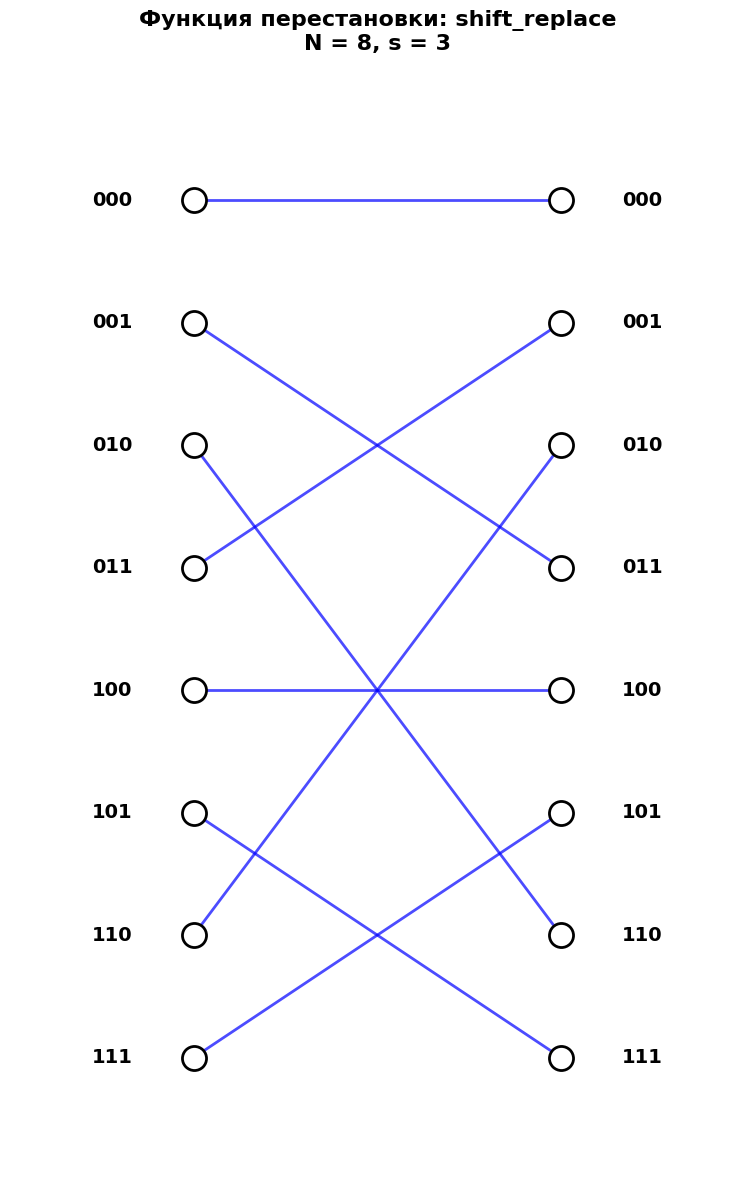

In [16]:
def shift_replace(i, s):
    n = 2**s
    return (i * closest_prime_to_sqrt(n)) % n


def is_prime(n):
    if n < 2:
        return False
    if n == 2:
        return True
    if n % 2 == 0:
        return False
    for i in range(3, int(sqrt(n)) + 1, 2):
        if n % i == 0:
            return False
    return True


@cache
def closest_prime_to_sqrt(N):
    target = int(sqrt(N))
    sqrt_n = sqrt(N)
    
    best_prime = None
    best_distance = float('inf')
    
    for offset in range(0, target + 1):
        for candidate in [target + offset, target - offset]:
            if candidate > 1 and is_prime(candidate):
                distance = abs(candidate - sqrt_n)
                if distance < best_distance:
                    best_distance = distance
                    best_prime = candidate
        
        if best_prime is not None and offset > best_distance:
            break
    
    return best_prime if best_prime is not None else 2


display_route_table(shift_replace, d.shift_S)
draw_permutation_scheme(shift_replace, d.shift_S)

### Тасование идеальное

i (дес),i (бин),SH(i) (дес),SH(i) (бин)
0,000,0,000
1,001,2,010
2,010,4,100
3,011,6,110
4,100,1,001
5,101,3,011
6,110,5,101
7,111,7,111


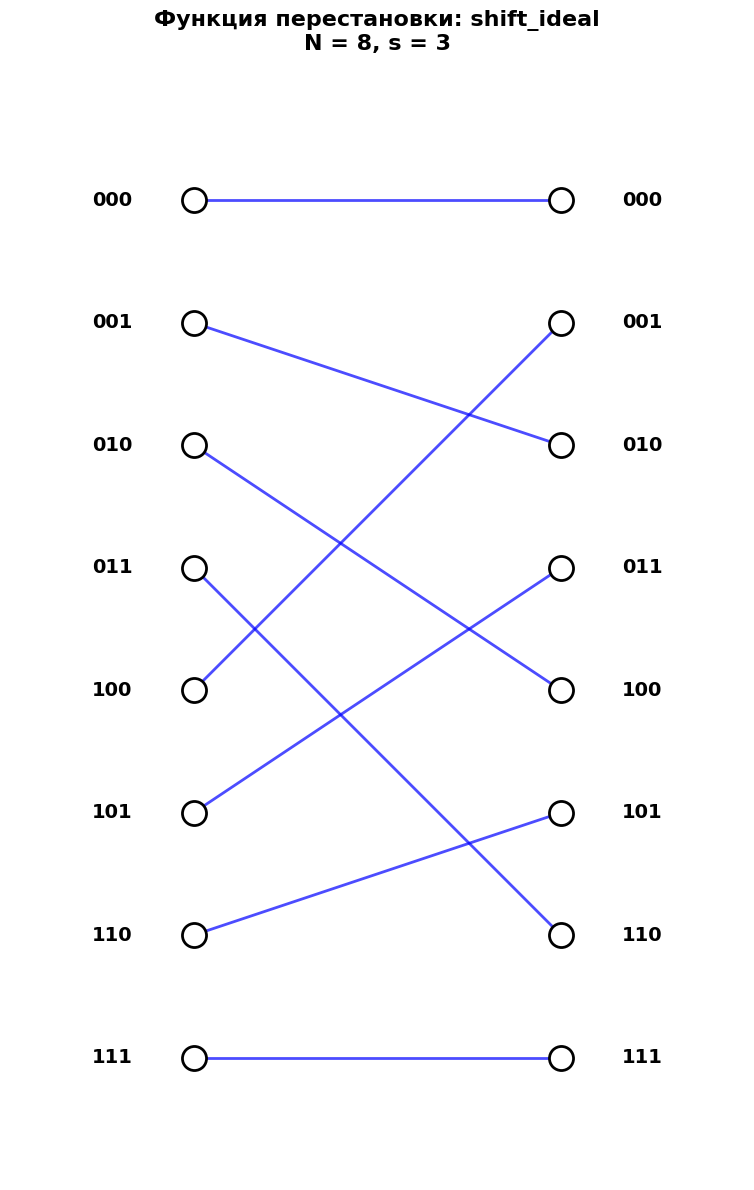

In [17]:

def shift_ideal(i, s):
    n = 2**s
    if i == n - 1:
        return i
    return (i << 1) % (n - 1)

display_route_table(shift_ideal, d.shift_S)
draw_permutation_scheme(shift_ideal, d.shift_S)

### Баттерфляй

i (дес),i (бин),SH(i) (дес),SH(i) (бин)
0,000,0,000
1,001,4,100
2,010,2,010
3,011,6,110
4,100,1,001
5,101,5,101
6,110,3,011
7,111,7,111


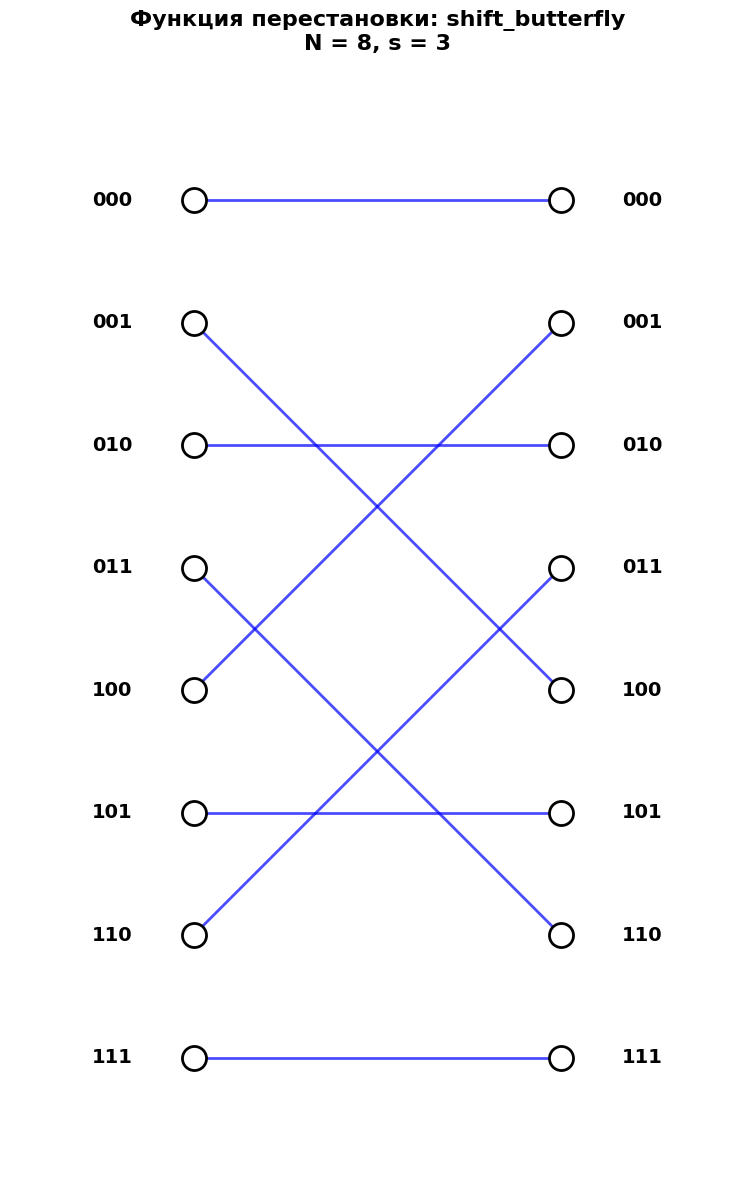

In [18]:
def shift_butterfly(i, s):
    msb = (i >> (s - 1)) & 1
    lsb = i & 1

    i = i & ~(1 << (s - 1))
    i = i & ~1

    i = i | (lsb << (s - 1))
    i = i | msb

    return i


display_route_table(shift_butterfly, d.shift_S)
draw_permutation_scheme(shift_butterfly, d.shift_S)

### Реверсирование битов

i (дес),i (бин),SH(i) (дес),SH(i) (бин)
0,000,0,000
1,001,4,100
2,010,2,010
3,011,6,110
4,100,1,001
5,101,5,101
6,110,3,011
7,111,7,111


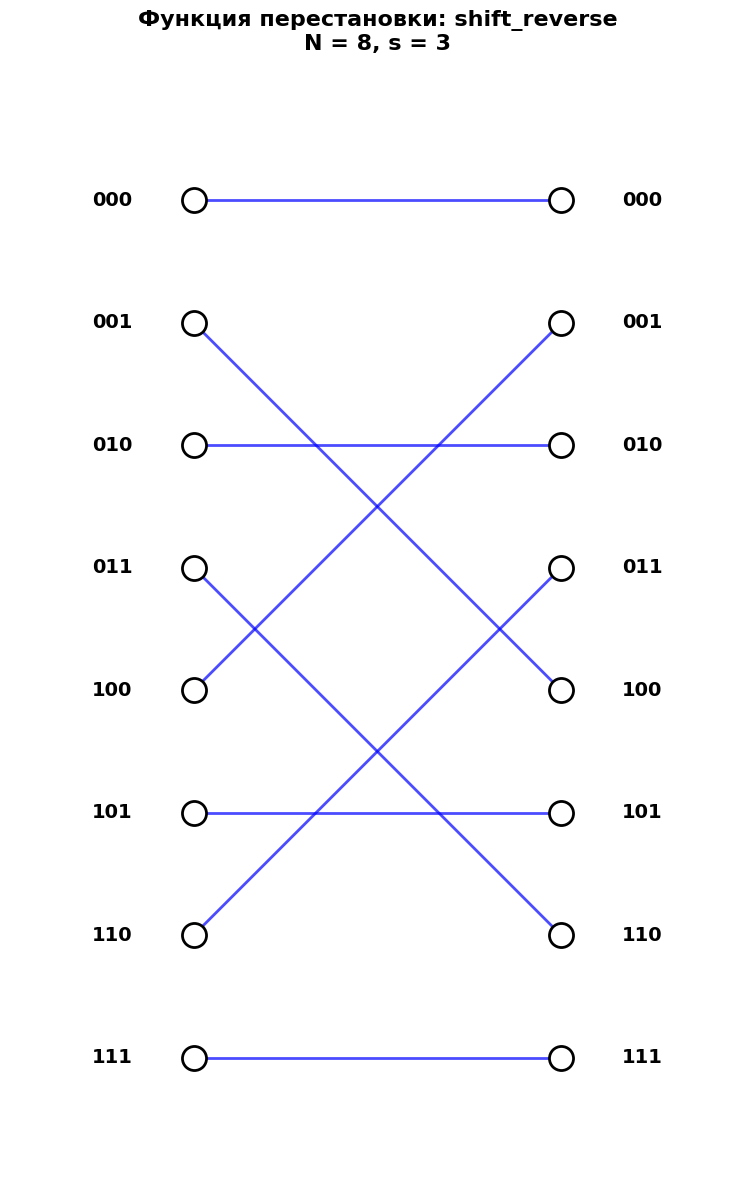

In [19]:
def shift_reverse(n, s):
    result = 0
    for i in range(s):
        result |= ((n >> i) & 1) << (s - 1 - i)
    return result


display_route_table(shift_reverse, d.shift_S)
draw_permutation_scheme(shift_reverse, d.shift_S)

### Сдвиг

i (дес),i (бин),SH(i) (дес),SH(i) (бин)
0,000,3,011
1,001,4,100
2,010,5,101
3,011,6,110
4,100,7,111
5,101,0,000
6,110,1,001
7,111,2,010


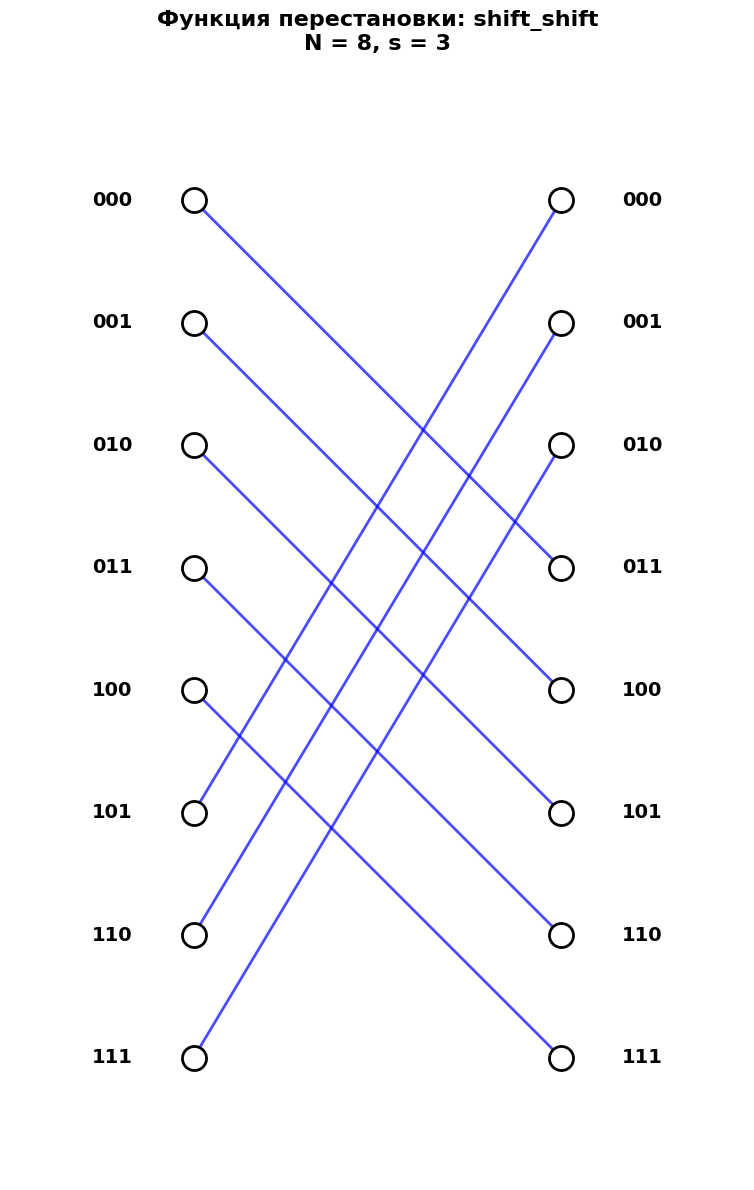

In [20]:
def shift_shift(i, s):
    return (i + s) % 2**s


display_route_table(shift_shift, d.shift_S)
draw_permutation_scheme(shift_shift, d.shift_S)

# Вывод

В рамках данной работы было проведено изучение ключевых топологий сетей межсоединений (полный граф, линейка, кольцо, звезда, B-дерево, гиперкуб, решётка). Для каждой топологии были рассчитаны и проанализированы структурные и коммуникационные метрики (диаметр, средняя степень вершины, ширина бисекции и др.), что позволило количественно оценить их эффективность, отказоустойчивость и масштабируемость.

На основе проведенного анализа установлено соответствие между топологическими характеристиками и архитектурными классами вычислительных систем (MIMD/SIMD/MISD, MPP/SMP/NUMA). Определены типовые области применения топологий, что подтверждается примерами реальных систем (CRAY T3E, SGI Origin, МВС-1000 и др.). Например, гиперкуб и полный граф, обладающие высокой связностью, оптимальны для задач с интенсивным обменом данными в MIMD-архитектурах, в то время как звезда и линейка лучше подходят для централизованного управления или конвейерной обработки.